In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import OneCycleLR
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torchvision.models as models
#from ocnn import losses



In [20]:
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_dataloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_dataloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [23]:
import torch
from torchvision import models

model=models.resnet18()
model.fc = nn.Linear(512, 10)

In [24]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())


loaders = {"train": train_dataloader, "test": test_dataloader}

In [25]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
model.to(device)

In [9]:
from itertools import chain

In [10]:
from sklearn.preprocessing import label_binarize
def plot_roc_log(y_true, y_scores):
    y_one_hot = label_binarize(y_true, classes = np.arange(10))
    fpr, tpr, threshold = roc_curve(y_one_hot.ravel(), y_scores.ravel())
    print(fpr)
    fpr1 = []
    roc_auc = metrics.auc(fpr, tpr)
    plt.figure()
    lw = 2
    plt.figure(figsize=(10, 10))
    plt.title('Receiver Operating Characteristic')
    plt.semilogx(fpr, tpr)
    ax = plt.gca()
    line = ax.lines[0]
    x = line.get_xdata()
    y = line.get_ydata()
    x = list(x)
    k = []
    for i in x:
        if i<0.0101 and i>=0.01:
            k.append(i)
    l = min(k)
    ind = x.index(l)
    #answ = y[x]
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.grid()
    plt.legend(loc="lower right")
    plt.show()
    return y[ind]

In [11]:
def plot_roc1(y_true, y_scores):
    y_one_hot = label_binarize(y_true, classes = np.arange(10))
    fpr, tpr, threshold = roc_curve(y_one_hot.ravel(), y_scores.ravel())
    return fpr,tpr,threshold

In [12]:
def plot_roc(y_true, y_scores):
    y_one_hot = label_binarize(y_true, classes = np.arange(10))
    fpr, tpr, threshold = roc_curve(y_one_hot.ravel(), y_scores.ravel())
    roc_auc = metrics.auc(fpr, tpr)
    plt.figure()
    lw = 2
    plt.figure(figsize=(10, 10))
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.grid()
    plt.legend(loc="lower right")
    plt.show()

In [13]:
def new_roc_curve(y_true, y_scores):
    y_one_hot = label_binarize(y_true, classes = np.arange(10))
    fpr, tpr, threshold = roc_curve(y_one_hot.ravel(), y_scores.ravel())
    x = list(fpr)
    k = []
    for i in x:
        if i>=0.01:
            k.append(i)
    l = min(k)
    ind = x.index(l)
    answ = tpr[ind]
    return fpr, tpr, answ

In [14]:
import sklearn.metrics as metrics
from sklearn.metrics import roc_curve

In [15]:
def evaluate(model, loaders):
    accuracy = []
    y_preds = []
    y_test = []
    y_probs = []
    y_probs3=[]
    epoch_correct = 0
    epoch_all = 0
    for x_batch, y_batch in loaders["test"]:
        #i+=1
        model.eval()
        with torch.no_grad():
            outp = model(x_batch.to(device))
            #print("outp:",outp)
        probs = F.softmax(outp, dim = 1)
        #print("probs:",probs)
        preds = outp.argmax(-1)
        #print("preds:",preds)
        y_probs3.append(probs.cpu().numpy())
        y_preds.append(preds.cpu().numpy())
        y_test.append(y_batch.cpu().numpy())
        correct = (preds == y_batch.to(device)).sum()
        all =  y_batch.size(0)
        epoch_correct += correct.item()
        epoch_all += all
    #print(f"Accuracy: {epoch_correct/epoch_all}")
    #accuracies.append(epoch_correct/epoch_all)
    y_probs1 = list(chain.from_iterable(y_probs3))
    y_test1 = list(chain.from_iterable(y_test))
    y_preds1 = list(chain.from_iterable(y_preds))
    #tpr1 - TPR при FPR = 10^-2
    accuracy = epoch_correct/epoch_all
    tpr, fpr, tpr1 = new_roc_curve(np.array(y_test1),np.array(y_probs1))
    #tpr_at_002_fprs.append(tpr1)
    return accuracy,tpr1,y_test1,y_probs1

# Обучение Baseline

In [18]:
def train2(loaders, model, criterion, optimizer, max_epochs):
    accuracy = {"train": [], "test": []}
    model.to(device)
    for epoch in range(max_epochs):
        for k, dataloader in loaders.items():
            epoch_correct = 0
            epoch_all = 0
            for x_batch, y_batch in dataloader:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                if k == "train":
                    model.train()
                    outp = model(x_batch.to(device))
                    optimizer.zero_grad()


                    loss = criterion(outp, y_batch.to(device))
                    loss.backward()
                    optimizer.step()
                #для валидационной части
                else:
                    model.eval()
                    with torch.no_grad():
                        outp = model(x_batch.to(device))
                preds = outp.argmax(-1)
                correct = (preds == y_batch.to(device)).sum()
                all =  y_batch.to(device).size(0)
                epoch_correct += correct.item()
                epoch_all += all
            if k == "train":
                print(f"Epoch: {epoch+1}")
            print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
            accuracy[k].append(epoch_correct/epoch_all)

In [ ]:
train2(loaders, model, criterion, optimizer, 10)

In [ ]:
optimizer = torch.optim.Adam(model.parameters())
train_sizes_pct = range(10, 100, 10) # доли от обучающей выборки
accuracies = [] # список для хранения accuracy
tpr_at_002_fprs = [] # список для хранения TPR при FPR=10^-2
# Проходимся циклом по всем долям обучающей выборки
for train_size_pct in train_sizes_pct:
    # Вычисляем размер обучающей выборки и создаем загрузчики данных
    train_size = int(len(trainset)*train_size_pct/100)
    train_dataset = torch.utils.data.Subset(trainset, range(train_size))
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False)

    loaders = {"train": train_loader, "test": test_loader}
    train2(loaders, model, criterion, optimizer, 5)

# Оцениваем качество модели на тестовой выборке и сохраняем метрики в списки
    accuracy, tpr_at_002_fpr,y_t,y_p = evaluate(model, loaders)
    accuracies.append(accuracy)
    tpr_at_002_fprs.append(tpr_at_002_fpr)
    #print("acc:",accuracy)
    #print("tpr:",tpr_at_002_fpr)

# Обучим ResNet18 с  OCNN  loss функцией

In [16]:
def deconv_orth_dist(kernel, stride = 2, padding = 1):
    [o_c, i_c, w, h] = kernel.shape
    output = torch.conv2d(kernel, kernel, stride=stride, padding=padding)
    target = torch.zeros((o_c, o_c, output.shape[-2], output.shape[-1]))
    target.to(device)
    ct = int(np.floor(output.shape[-1]/2))
    target[:,:,ct,ct] = torch.eye(o_c)
    return torch.norm( output.to(device) - target.to(device) )

def orth_dist(mat, stride=None):
    mat = mat.reshape( (mat.shape[0], -1) )
    mat.to(device)
    if mat.shape[0] < mat.shape[1]:
        mat = mat.permute(1,0)
    mat.to(device)
    return torch.norm( torch.t(mat)@mat.to(device) - torch.eye(mat.shape[1]).to(device)).to(device)

In [17]:
def train(loaders, model, criterion, optimizer, max_epochs, args):
    accuracy = {"train": [], "test": []}
    model.to(device)
    for epoch in range(max_epochs):
        for k, dataloader in loaders.items():
            epoch_correct = 0
            epoch_all = 0
            for x_batch, y_batch in dataloader:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                if k == "train":
                    model.train()
                    outp = model(x_batch.to(device))
                    optimizer.zero_grad()

                    diff = orth_dist(model.conv1.weight) + orth_dist(model.layer2[0].downsample[0].weight) + orth_dist(model.layer3[0].downsample[0].weight) + orth_dist(model.layer4[0].downsample[0].weight)
                    diff += deconv_orth_dist(model.layer1[0].conv1.weight, stride=1) + deconv_orth_dist(model.layer1[0].conv2.weight, stride=1) + deconv_orth_dist(model.layer1[1].conv1.weight, stride=1) + deconv_orth_dist(model.layer1[1].conv2.weight, stride=1)
                    diff += deconv_orth_dist(model.layer2[0].conv1.weight, stride=2) + deconv_orth_dist(model.layer2[0].conv2.weight, stride=1) + deconv_orth_dist(model.layer2[1].conv1.weight, stride=1) + deconv_orth_dist(model.layer2[1].conv2.weight, stride=1)
                    diff += deconv_orth_dist(model.layer3[0].conv1.weight, stride=2) + deconv_orth_dist(model.layer3[0].conv2.weight, stride=1) + deconv_orth_dist(model.layer3[1].conv1.weight, stride=1) + deconv_orth_dist(model.layer3[1].conv2.weight, stride=1)
                    diff += deconv_orth_dist(model.layer4[0].conv1.weight, stride=2) + deconv_orth_dist(model.layer4[0].conv2.weight, stride=1) + deconv_orth_dist(model.layer4[1].conv1.weight, stride=1) + deconv_orth_dist(model.layer4[1].conv2.weight, stride=1)

                    loss = criterion(outp, y_batch.to(device)) + args*diff
                    loss.backward()
                    optimizer.step()
                #для валидационной части
                else:
                    model.eval()
                    with torch.no_grad():
                        outp = model(x_batch.to(device))
                preds = outp.argmax(-1)
                correct = (preds == y_batch.to(device)).sum()
                all =  y_batch.to(device).size(0)
                epoch_correct += correct.item()
                epoch_all += all
            if k == "train":
                print(f"Epoch: {epoch+1}")
            print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
            accuracy[k].append(epoch_correct/epoch_all)

In [ ]:
max_epochs = 10
lmbda = 1
model_oc=models.resnet18()
model_oc.fc = nn.Linear(512, 10)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_oc.parameters())
loaders = {"train": train_dataloader, "test": test_dataloader}
device = "cuda" if torch.cuda.is_available() else "cpu"
model_oc.to(device)

In [ ]:
train(loaders, model_oc, criterion, optimizer, max_epochs, lmbda)

In [ ]:
optimizer = torch.optim.Adam(model_oc.parameters())
train_sizes_pct = range(10, 100, 10) # доли от обучающей выборки
accuracies_oc = [] # список для хранения accuracy
tpr_at_002_fprs_oc = [] # список для хранения TPR при FPR=10^-2
# Проходимся циклом по всем долям обучающей выборки
for train_size_pct in train_sizes_pct:
    # Вычисляем размер обучающей выборки и создаем загрузчики данных
    train_size = int(len(trainset)*train_size_pct/100)
    train_dataset = torch.utils.data.Subset(trainset, range(train_size))
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False)

    loaders = {"train": train_loader, "test": test_loader}
    train(loaders, model_oc, criterion, optimizer, 5, lmbda)

# Оцениваем качество модели на тестовой выборке и сохраняем метрики в списки
    accuracy_oc, tpr_at_002_fpr_oc, y_t1,y_p1 = evaluate(model_oc, loaders)
    accuracies_oc.append(accuracy_oc)
    tpr_at_002_fprs_oc.append(tpr_at_002_fpr_oc)
    print("acc:",accuracy_oc)
    print("tpr:",tpr_at_002_fpr_oc)

In [ ]:
def s_matrix(layer_name,model):
    w = np.zeros((model.state_dict()[layer_name+'.weight'].shape[0],model.state_dict()[layer_name+'.weight'].shape[1]*
    model.state_dict()[layer_name+'.weight'].shape[2]**2))
    for i in range(model.state_dict()[layer_name+'.weight'].shape[0]):
        w[i]= model.state_dict()[layer_name+'.weight'][i].ravel().cpu()
    #print(w.shape)
    #corr_matrix = w.dot(w.T)
    corr_mt = np.corrcoef(w)
    sf = np.linalg.svd(corr_mt,full_matrices=False,compute_uv=False)
    s = np.diag(sf)
    sgm_lst1 = []
    n_lst1 = []
    sgm = 0
    for i in range(s.shape[0]):
        sgm += s[i][i]**2
        sgm_lst1.append(sgm)
        n_lst1.append(i+1)
    sgm_lst2 = sgm_lst1/sgm_lst1[s.shape[0]-1]
    sgm_lst2 = list(sgm_lst2)
    #for i in range(len(n_lst1), 512):
        #sgm_lst2.append(1)
    return s, sgm_lst2, n_lst1


In [35]:
import statistics
def s_matrix1(layer_name,model):
    w = np.zeros((model.state_dict()[layer_name+'.weight'].shape[0],model.state_dict()[layer_name+'.weight'].shape[1]*
    model.state_dict()[layer_name+'.weight'].shape[2]**2))
    for i in range(model.state_dict()[layer_name+'.weight'].shape[0]):
        w[i]= model.state_dict()[layer_name+'.weight'][i].ravel().cpu()
    #print(w.shape)
    #corr_matrix = w.dot(w.T)
    corr_mt = np.corrcoef(w)
    sf = np.linalg.svd(corr_mt,full_matrices=False,compute_uv=False)
    s = np.diag(sf)
    sgm_lst1 = []
    n_lst1 = []
    sp_lst1 = []
    s_lst = []
    sgm = 0
    for i in range(s.shape[0]):
        sgm += s[i][i]**2
        sgm_lst1.append(sgm)
        sp_lst1.append(s[i][i]**2)
        n_lst1.append(i+1)
        s_lst.append(s[i][i])
    sgm_lst2 = sgm_lst1/(max(sgm_lst1))
    sgm_lst2 = list(sgm_lst2)
    rel = max(sp_lst1)/(min(sp_lst1)+0.0001)
    new = min(s_lst)/max(s_lst)
    s_lst1 = s_lst/max(s_lst)
    sp_lst = sp_lst1/(max(sp_lst1))
    avg = statistics.mean(sp_lst)
    print('max in ', layer_name, ': ', max(s_lst))
    print('min in ',layer_name,': ', min(s_lst))
    #for i in range(len(n_lst1), 512):
        #sgm_lst2.append(1)
    return corr_mt, sgm_lst2, n_lst1, rel, avg

Для baseline

In [ ]:
bs1, bsgm_lst5, bn_lst3, brel3, bavg3 = s_matrix1('conv1',model)
bs2, bsgm_lst45, bn_lst45, brel45, bavg45 = s_matrix1('layer1.0.conv1',model)
bs3, bsgm_lst6, bn_lst06, brel4, bavg4 = s_matrix1('layer1.0.conv2',model)
bs4, bsgm_lst11, bn_lst011,brel8,bavg8 = s_matrix1('layer1.1.conv1',model)
bs5, bsgm_lst7, bn_lst07, brel5, bavg5 = s_matrix1('layer1.1.conv2',model)
bs6, bsgm_lst8, bn_lst08, brel56, bavg56 = s_matrix1('layer2.0.conv1',model)
bs7, bsgm_lst80, bn_lst80, brel6, bavg6 = s_matrix1('layer2.0.conv2',model)
bs8, bsgm_lst4, bn_lst4, brel66, bavg66 = s_matrix1('layer2.1.conv1',model)
bs9, bsgm_lst40, bn_lst40, brel, bavg = s_matrix1('layer2.1.conv2',model)
bs10, bsgm_lst77, bn_lst77,brel77, bavg77 = s_matrix1('layer3.0.conv1',model)
bs11, bsgm_lst78, bn_lst78,brel78, bavg78 = s_matrix1('layer3.0.conv2',model)
bs12, bsgm_lst79, bn_lst79,brel79, bavg79 = s_matrix1('layer3.1.conv1',model)
bs13, bsgm_lst81, bn_lst81,brel81, bavg81 = s_matrix1('layer3.1.conv2',model)
bs14, bsgm_lst10, bn_lst010,brel7, bavg7 = s_matrix1('layer4.0.conv1',model)
bs15, bsgm_lst82, bn_lst82,brel82, bavg82 = s_matrix1('layer4.0.conv2',model)
bs16, bsgm_lst33, bn_lst29, brel83, bavg83 = s_matrix1('layer4.1.conv1',model)
bs17, bsgm_lst3, bn_lst2, brel2, bavg2 = s_matrix1('layer4.1.conv2',model)

In [40]:
bn_lst33 = []
for i in bn_lst06:
    i = i/64*100
    bn_lst33.append(i)
bn_lst44 = []
for i in bn_lst011:
    i = i/64*100
    bn_lst44.append(i)
bn_lst66 = []
for i in bn_lst08:
    i = i/128*100
    bn_lst66.append(i)
bn_lst99 = []
for i in bn_lst40:
    i = i/128*100
    bn_lst99.append(i)
bn_lst100 = []
for i in bn_lst77:
    i = i/256*100
    bn_lst100.append(i)
bn_lst144 = []
for i in bn_lst010:
    i = i/512*100
    bn_lst144.append(i)
bn_lst177 = []
for i in bn_lst2:
    i = i/512*100
    bn_lst177.append(i)

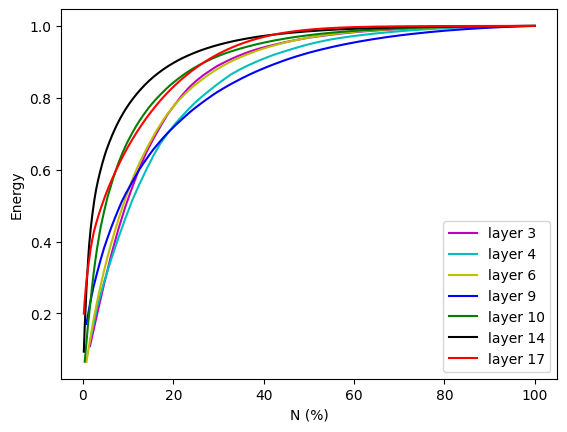

In [ ]:
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots()

ax1.set_xlabel('N (%)')
ax1.set_ylabel('Energy')


ax1.plot(bn_lst33, bsgm_lst6, 'm-', label = 'layer 3')
ax1.plot(bn_lst44, bsgm_lst11, 'c-', label = 'layer 4')
ax1.plot(bn_lst66, bsgm_lst8, 'y-', label = 'layer 6')
ax1.plot(bn_lst99, bsgm_lst40, 'b-', label = 'layer 9')
ax1.plot(bn_lst100, bsgm_lst77, 'g-', label = 'layer 10')
ax1.plot(bn_lst144, bsgm_lst10, 'k-', label = 'layer 14')
ax1.plot(bn_lst177, bsgm_lst3, 'r-', label = 'layer 17')
#plt.title('Energy in Baseline')
plt.legend()
plt.show()

Для OCNN

In [ ]:
s1, sgm_lst5, n_lst3, rel3, avg3 = s_matrix1('conv1',model_oc)
s2, sgm_lst45, n_lst45, rel45, avg45 = s_matrix1('layer1.0.conv1',model_oc)
s3, sgm_lst6, n_lst06, rel4, avg4 = s_matrix1('layer1.0.conv2',model_oc)
s4, sgm_lst11, n_lst011,rel8,avg8 = s_matrix1('layer1.1.conv1',model_oc)
s5, sgm_lst7, n_lst07, rel5, avg5 = s_matrix1('layer1.1.conv2',model_oc)
s6, sgm_lst8, n_lst08, rel56, avg56 = s_matrix1('layer2.0.conv1',model_oc)
s7, sgm_lst80, n_lst80, rel6, avg6 = s_matrix1('layer2.0.conv2',model_oc)
s8, sgm_lst4, n_lst4, rel66, avg66 = s_matrix1('layer2.1.conv1',model_oc)
s9, sgm_lst40, n_lst40, rel, avg = s_matrix1('layer2.1.conv2',model_oc)
s10, sgm_lst77, n_lst77,rel77, avg77 = s_matrix1('layer3.0.conv1',model_oc)
s11, sgm_lst78, n_lst78,rel78, avg78 = s_matrix1('layer3.0.conv2',model_oc)
s12, sgm_lst79, n_lst79,rel79, avg79 = s_matrix1('layer3.1.conv1',model_oc)
s13, sgm_lst81, n_lst81,rel81, avg81 = s_matrix1('layer3.1.conv2',model_oc)
s14, sgm_lst10, n_lst010,rel7, avg7 = s_matrix1('layer4.0.conv1',model_oc)
s15, sgm_lst82, n_lst82,rel82, avg82 = s_matrix1('layer4.0.conv2',model_oc)
s16, sgm_lst3, n_lst29, rel83, avg83 = s_matrix1('layer4.1.conv1',model_oc)
s17, sgm_lst3, n_lst2, rel2, avg2 = s_matrix1('layer4.1.conv2',model_oc)

In [43]:
n_lst33 = []
for i in n_lst06:
    i = i/64*100
    n_lst33.append(i)
n_lst44 = []
for i in n_lst011:
    i = i/64*100
    n_lst44.append(i)
n_lst66 = []
for i in n_lst08:
    i = i/128*100
    n_lst66.append(i)
n_lst99 = []
for i in n_lst40:
    i = i/128*100
    n_lst99.append(i)
n_lst100 = []
for i in n_lst77:
    i = i/256*100
    n_lst100.append(i)
n_lst144 = []
for i in n_lst010:
    i = i/512*100
    n_lst144.append(i)
n_lst177 = []
for i in n_lst2:
    i = i/512*100
    n_lst177.append(i)

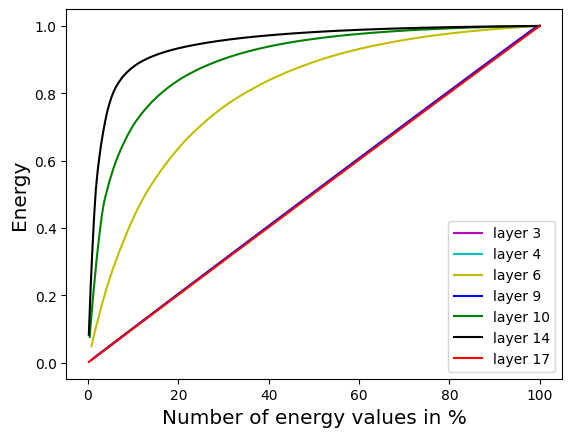

In [50]:
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots()

ax1.set_xlabel('Number of energy values in %', fontsize = "x-large")
ax1.set_ylabel('Energy',fontsize = "x-large")


ax1.plot(n_lst33, sgm_lst6, 'm-', label = 'layer 3')
ax1.plot(n_lst44, sgm_lst11, 'c-', label = 'layer 4')
ax1.plot(n_lst66, sgm_lst8, 'y-', label = 'layer 6')
ax1.plot(n_lst99, sgm_lst40, 'b-', label = 'layer 9')
ax1.plot(n_lst100, sgm_lst77, 'g-', label = 'layer 10')
ax1.plot(n_lst144, sgm_lst10, 'k-', label = 'layer 14')
ax1.plot(n_lst177, sgm_lst3, 'r-', label = 'layer 17')
#plt.title('Energy in Baseline')
plt.legend()
plt.show()


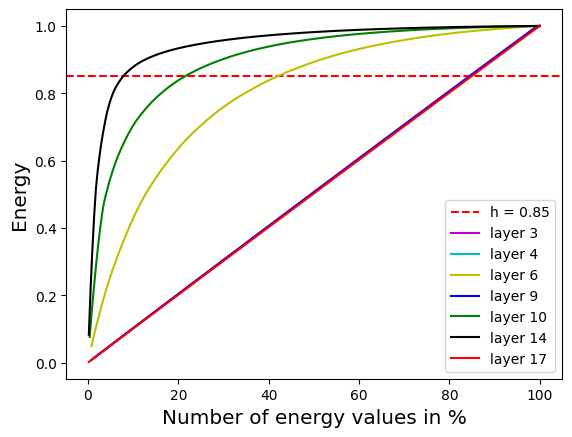

In [51]:
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots()

ax1.set_xlabel('Number of energy values in %', fontsize = "x-large")
ax1.set_ylabel('Energy',fontsize = "x-large")

plt.axhline(y = 0.85, color = 'r', label = 'h = 0.85', linestyle="--")
ax1.plot(n_lst33, sgm_lst6, 'm-', label = 'layer 3')
ax1.plot(n_lst44, sgm_lst11, 'c-', label = 'layer 4')
ax1.plot(n_lst66, sgm_lst8, 'y-', label = 'layer 6')
ax1.plot(n_lst99, sgm_lst40, 'b-', label = 'layer 9')
ax1.plot(n_lst100, sgm_lst77, 'g-', label = 'layer 10')
ax1.plot(n_lst144, sgm_lst10, 'k-', label = 'layer 14')
ax1.plot(n_lst177, sgm_lst3, 'r-', label = 'layer 17')
#plt.title('Energy in Baseline')
plt.legend()
plt.show()

In [52]:
def cond_num(c_lst,answ_lst,per):
    k = []
    for i in c_lst:
        if i>=per and i<=per+2:
            k.append(i)
    l = min(k)
    ind = c_lst.index(l)
    answ = answ_lst[ind]
    return answ

In [ ]:
del_lst = []

In [54]:
answ1 = cond_num(sgm_lst5,n_lst3,0.85)
answ6 = cond_num(sgm_lst8,n_lst08,0.85)
answ10 = cond_num(sgm_lst77,n_lst77,0.85)
answ14 = cond_num(sgm_lst10,n_lst010,0.85)
new_answ1 = 64 - answ1
#print('answ1 = ', answ1)
#print('answ6 = ', answ6)
#print('answ10 = ', answ10)
#print('answ14 = ', answ14)
new_answ6 = 128-answ6
new_answ10 = 256-answ10
new_answ14 = 512-answ14
#print(new_answ6*64+new_answ1*3+new_answ10*128+new_answ14*256)
del_conds = new_answ6+new_answ1+new_answ10+new_answ14
#110466  удаляем - 0.9
#130114 удаляем - 0.85
#143490 удаляем- 0.8
#157826 удалям - 0.7
#163842 удаляем - 0.6
#166594 удаляем - 0.5
#168450 удаляем - 0.4

In [55]:
import copy
def cnt1(s6,model_oc,layer_name,new_answ6):
    corr_mt = s6
    model2 = copy.deepcopy(model_oc)
    #acc_list2 = []
    #rel_lst = []
    tens = model2.state_dict()[layer_name+'.weight']
    #for i in range(corr_mt.shape[0]):
      #corr_mt[i][i] = 0
    for i in range(new_answ6):
        sum_lst = []
        for i in range(corr_mt.shape[0]):
          sum_lst.append(np.sum(np.abs(corr_mt[i])))
        max_elem = np.max(sum_lst)
        max_index = np.argmax(sum_lst)
        #max_index_2d = np.unravel_index(max_index,corr_mt.shape)
        #i = max_index_2d[0]
        #j = max_index_2d[1]
        corr_mt = np.delete(corr_mt,[max_index],0)
        corr_mt = np.delete(corr_mt,np.s_[max_index],1)
        #corr_mt2[i] = 0
        #corr_mt2[:][i] = 0
        #max_index_2d1 = np.unravel_index(j, (tens.shape[0],tens.shape[1]))
        #i_new = max_index_2d1[0]
        #j_new = max_index_2d1[1]
        for i in range(tens.shape[1]):
          model2.state_dict()[layer_name+'.weight'][max_index][i] = torch.tensor(np.zeros((7,7)))
    sf = np.linalg.svd(corr_mt,full_matrices=False,compute_uv=False)
    s = np.diag(sf)
    s_lst = []
    sgm = 0
    for i in range(s.shape[0]):
        sgm += s[i][i]**2
        s_lst.append(s[i][i]**2)
    s_lst1 = s_lst/max(s_lst)
    rel = max(s_lst1)/(min(s_lst1)+0.0001)
    avg = np.mean(s_lst1)
    return model2,rel,rel,avg

In [56]:
import copy
def cnt(s6,model_oc,layer_name,new_answ6):
    corr_mt = s6
    model2 = copy.deepcopy(model_oc)
    #acc_list2 = []
    #rel_lst = []
    tens = model2.state_dict()[layer_name+'.weight']
    #for i in range(corr_mt.shape[0]):
      #corr_mt[i][i] = 0
    for i in range(new_answ6):
        sum_lst = []
        for i in range(corr_mt.shape[0]):
          sum_lst.append(np.sum(np.abs(corr_mt[i])))
        max_elem = np.max(sum_lst)
        max_index = np.argmax(sum_lst)
        #max_index_2d = np.unravel_index(max_index,corr_mt.shape)
        #i = max_index_2d[0]
        #j = max_index_2d[1]
        corr_mt = np.delete(corr_mt,[max_index],0)
        corr_mt = np.delete(corr_mt,np.s_[max_index],1)
        #corr_mt2[i] = 0
        #corr_mt2[:][i] = 0
        #max_index_2d1 = np.unravel_index(j, (tens.shape[0],tens.shape[1]))
        #i_new = max_index_2d1[0]
        #j_new = max_index_2d1[1]
        for i in range(tens.shape[1]):
          model2.state_dict()[layer_name+'.weight'][max_index][i] = torch.tensor(np.zeros((3,3)))
    sf = np.linalg.svd(corr_mt,full_matrices=False,compute_uv=False)
    s = np.diag(sf)
    s_lst = []
    sgm = 0
    for i in range(s.shape[0]):
        sgm += s[i][i]**2
        s_lst.append(s[i][i]**2)
    s_lst1 = s_lst/max(s_lst)
    rel = max(s_lst)/(min(s_lst)+0.0001)
    avg = np.mean(s_lst1)
    return model2,rel,avg

In [57]:
#model2.state_dict()['layer2.0.conv1'+'.weight'][0].shape
model2,rel006,avg006 = cnt(s6,model_oc,'layer2.0.conv1',new_answ6)
model3,rel0010,avg0010 = cnt(s10,model2,'layer3.0.conv1',new_answ10)
model4,rel0014,avg0014 = cnt(s14,model3,'layer4.0.conv1',new_answ14)
model5,rel001,avg001 = cnt1(s1,model4,'conv1',new_answ1)
#print(rel006)

In [61]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model5.parameters())
loaders = {"train": train_dataloader, "test": test_dataloader}
#for name, layer in model5.named_parameters():
    #if ('layer2.0.conv1' in name) or ('layer3.0.conv1' in name) or ('layer4.0.conv1' in name) or (name =='conv1'):
        #layer.requires_grad = False
#train(loaders, model5, criterion, optimizer, 5, lmbda)
acc, tpr,y_1,y_2 = evaluate(model5, loaders)
print(acc)


acc_lst = [0.6856,0.7028,0.706,0.7116,0.7128, 0.7214,0.7219,0.7246,0.7249]
#acc_lst_new.append(acc)

0.7111


In [63]:
optimizer = torch.optim.Adam(model5.parameters())
train_sizes_pct = range(10, 100, 10) # доли от обучающей выборки
accuracies_oc_red = [] # список для хранения accuracy
tpr_at_002_fprs_oc_red = [] # список для хранения TPR при FPR=10^-2
# Проходимся циклом по всем долям обучающей выборки
for train_size_pct in train_sizes_pct:
    # Вычисляем размер обучающей выборки и создаем загрузчики данных
    train_size = int(len(trainset)*train_size_pct/100)
    train_dataset = torch.utils.data.Subset(trainset, range(train_size))
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False)

    loaders = {"train": train_loader, "test": test_loader}
    train(loaders, model5, criterion, optimizer, 5, lmbda)

# Оцениваем качество модели на тестовой выборке и сохраняем метрики в списки
    accuracy_oc_red, tpr_at_002_fpr_oc_red,y_1,y_2 = evaluate(model5, loaders)
    accuracies_oc_red.append(accuracy_oc_red)
    tpr_at_002_fprs_oc_red.append(tpr_at_002_fpr_oc_red)
    print("acc:",accuracy_oc_red)
    print("tpr:",tpr_at_002_fpr_oc_red)

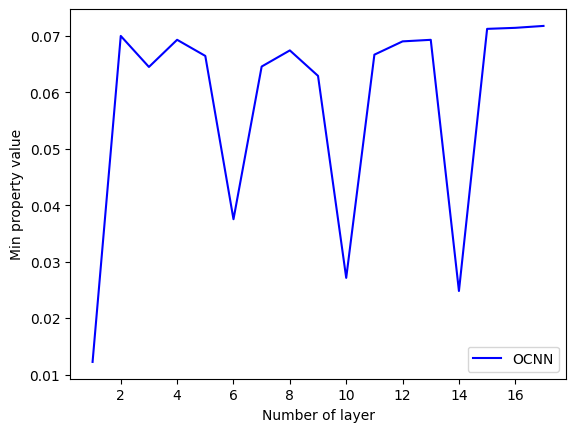

In [ ]:
layer_num = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots()
ax1.set_xlabel('Number of layer')
ax1.set_ylabel('Min property value')
ax1.plot(layer_num, avg_lst1, 'b-', label = 'OCNN')
#plt.axhline(y = 1, color = 'r', label = '', linestyle="--")
#plt.title('Model Performance vs Train Set Size')
plt.legend()
plt.show()

Text(0.5, 0, '')

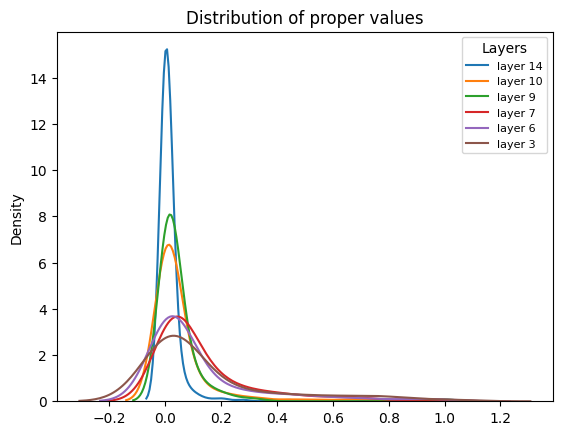

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
x = 0
# matplotlib histogram
for i in setl:
  #sns.distplot(i, hist = False, kde = True,
      #            kde_kws = {'linewidth': 1}, label = k[x])
  sns.kdeplot(i,log_scale = False,label = k[x])
  x += 1
plt.legend(prop={'size': 8}, title = 'Layers')
plt.title('Distribution of proper values')
plt.xlabel('')
#corr_mt14

In [ ]:
setl = [avg7,avg77,avg,avg6,avg56,avg4]
k = ['layer 14','layer 10','layer 9','layer 7','layer 6', 'layer 3']

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
x = 0
# matplotlib histogram
for i in setl:
  sns.distplot(i, hist = False, kde = True,
                  kde_kws = {'linewidth': 2}, label = k[x])
  x += 1
plt.legend(prop={'size': 8}, title = 'Layers')
plt.title('Distribution of singular numbers')
plt.xlabel('')
#corr_mt14

In [ ]:
setl = [avg7,avg77,avg56,avg4]
k = ['layer 14','layer 10','layer 7', 'layer 3']

In [ ]:
setl = [sgm_lst10,sgm_lst12,sgm_lst8,sgm_lst6]
k = ['layer 14','layer 10','layer 7', 'layer 3']

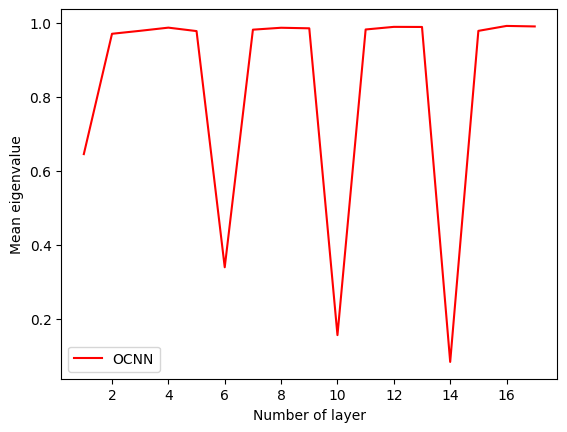

In [64]:
layer_num = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]
avg_lst = [avg3,avg45,avg4,avg8,avg5,avg56,avg6,avg66,avg,avg77,avg78,avg79,avg81,avg7,avg82,avg83,avg2]
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots()
ax1.set_xlabel('Number of layer')
ax1.set_ylabel('Mean eigenvalue')
ax1.plot(layer_num, avg_lst, 'r-', label = 'OCNN')
#plt.title('Model Performance vs Train Set Size')
plt.legend()
plt.show()

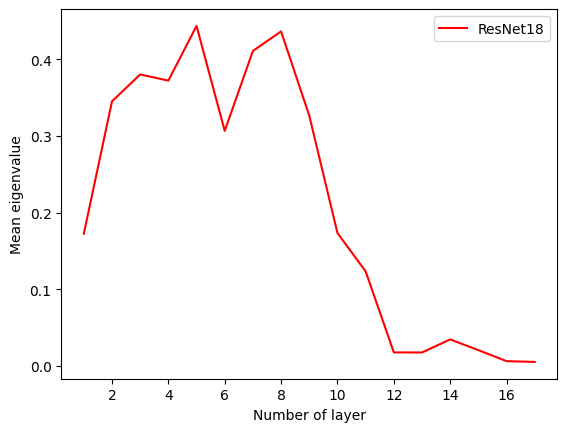

In [66]:
layer_num = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]
avg_lst = [bavg3,bavg45,bavg4,bavg8,bavg5,bavg56,bavg6,bavg66,bavg,bavg77,bavg78,bavg79,bavg81,bavg7,bavg82,bavg83,bavg2]
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots()
ax1.set_xlabel('Number of layer')
ax1.set_ylabel('Mean eigenvalue')
ax1.plot(layer_num, avg_lst, 'r-', label = "ResNet18")
#plt.title('Model Performance vs Train Set Size')
plt.legend()
plt.show()

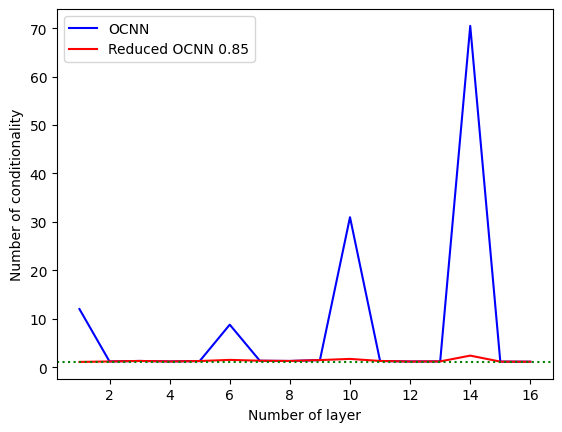

In [ ]:
layer_num = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
avg_lst = [rel3,rel45,rel4,rel8,rel5,rel56,rel6,rel66,rel,rel77,rel78,rel79,rel81,rel7,rel82,rel83]
avg_lst2 = [rel001,rel45,rel4,rel8,rel5,rel006,rel6,rel66,rel,rel0010,rel78,rel79,rel81,rel0014,rel82,rel83]
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots()
ax1.set_xlabel('Number of layer')
ax1.set_ylabel('Number of conditionality')
ax1.plot(layer_num, avg_lst, 'b-', label = 'OCNN')
ax1.plot(layer_num, avg_lst2, 'r-', label = 'Reduced OCNN 0.85')
plt.axhline(y = 1, color = 'g', label = '', linestyle='dotted')
#plt.title('Model Performance vs Train Set Size')
plt.legend()
plt.show()

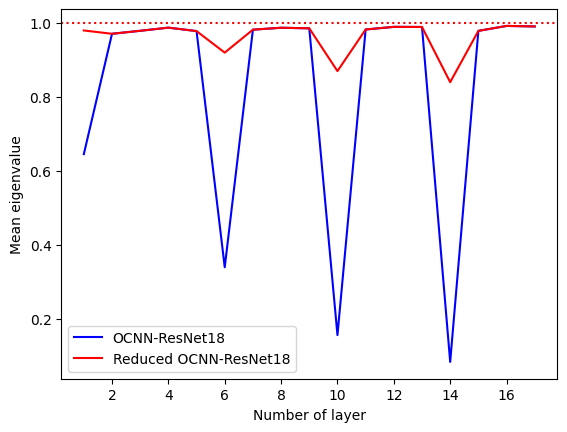

In [80]:
layer_num = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]
avg_lst = [avg3,avg45,avg4,avg8,avg5,avg56,avg6,avg66,avg,avg77,avg78,avg79,avg81,avg7,avg82,avg83,avg2]
avg_lst2 = [avg001,avg45,avg4,avg8,avg5,avg006,avg6,avg66,avg,avg0010,avg78,avg79,avg81,avg0014,avg82,avg83,avg2]
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots()
ax1.set_xlabel('Number of layer')
ax1.set_ylabel('Mean eigenvalue')
ax1.plot(layer_num, avg_lst, 'b-', label = 'OCNN-ResNet18')
ax1.plot(layer_num, avg_lst2, 'r-', label = 'Reduced OCNN-ResNet18')
plt.axhline(y = 1, color = 'r', label = '', linestyle='dotted')
#plt.title('Model Performance vs Train Set Size')
plt.legend()
plt.show()

In [ ]:
accur,tprr = evaluate(model_oc,loaders)

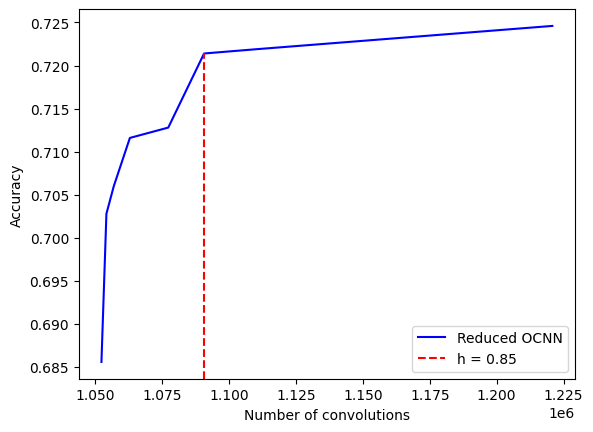

In [ ]:
acc_lst = [0.6856,0.7028,0.706,0.7116,0.7128, 0.7214,0.7219,0.7246]
del_lst = [1052350,1054206,1056958,1062974,1077310,1090686,1110334,1220800]
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots()
ax1.set_xlabel('Number of convolutions')
ax1.set_ylabel('Accuracy')
ax1.plot(del_lst, acc_lst, 'b-', label = 'Reduced OCNN')
plt.axvline(x = 1090686, color = 'r', label = 'h = 0.85', linestyle='--', ymax = 0.88)
#plt.title('Model Performance vs Train Set Size')
plt.legend()
plt.show()

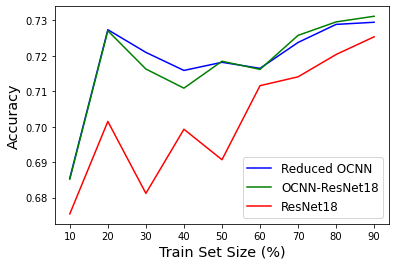

In [ ]:
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots()
ax1.plot(train_sizes_pct, accuracies_oc_red, 'b-', label = 'Reduced OCNN')
ax1.plot(train_sizes_pct, accuracies_oc, 'g-', label = 'OCNN-ResNet18')
ax1.set_xlabel('Train Set Size (%)',fontsize = "x-large")
ax1.set_ylabel('Accuracy',fontsize = "x-large")
#ax2 = ax1.twinx()
ax1.plot(train_sizes_pct, accuracies, 'r-', label = 'ResNet18')
#ax2.set_ylabel('True Positive Rate (TPR) at FPR=10^-2', color='r')
#plt.title('Model Performance vs Train Set Size')
plt.legend(fontsize = "large")
plt.show()

In [69]:
def plot_roc1(y_true, y_scores):
    y_one_hot = label_binarize(y_true, classes = np.arange(10))
    fpr, tpr, threshold = roc_curve(y_one_hot.ravel(), y_scores.ravel())
    return fpr,tpr,threshold

In [77]:
acc01,tpr01,y_test01,y_probs01 = evaluate(model,loaders)
acc02,tpr02,y_test02,y_probs02 = evaluate(model_oc,loaders)
acc03,tpr03,y_test03,y_probs03 = evaluate(model5,loaders)

<ipython-input-78-803af7b022c8>:17: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim([0.0, 1.0])


<Figure size 640x480 with 0 Axes>

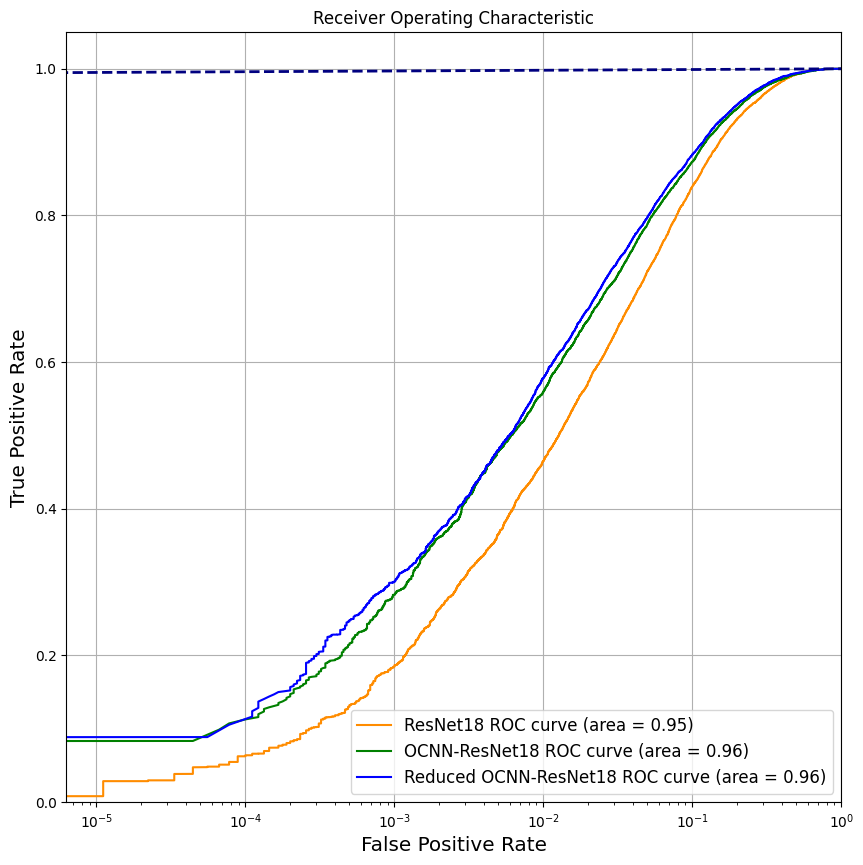

In [78]:
fpr,tpr,trs = plot_roc1(np.array(y_test01),np.array(y_probs01))
fpr1,tpr1, trs = plot_roc1(np.array(y_test02),np.array(y_probs02))
fpr2,tpr2, trs = plot_roc1(np.array(y_test03),np.array(y_probs03))
roc_auc = metrics.auc(fpr, tpr)
roc_auc1 = metrics.auc(fpr1, tpr1)
roc_auc2 = metrics.auc(fpr2, tpr2)
plt.figure()
lw = 2
plt.figure(figsize=(10, 10))
plt.title('Receiver Operating Characteristic',fontsize='large')
plt.semilogx(fpr, tpr, color = 'darkorange', label='ResNet18 ROC curve (area = %0.2f)' % roc_auc)
plt.semilogx(fpr1, tpr1, color = 'green', label='OCNN-ResNet18 ROC curve (area = %0.2f)' % roc_auc1)
plt.semilogx(fpr2, tpr2, color = 'blue', label='Reduced OCNN-ResNet18 ROC curve (area = %0.2f)' % roc_auc2)
#plt.semilogx(fpr2, tpr2, color = 'blue', label='Reduced OCNN ROC curve (area = %0.2f)' % roc_auc2)
ax = plt.gca()
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.ylabel('True Positive Rate', fontsize='x-large')
plt.xlabel('False Positive Rate',fontsize='x-large')
plt.grid()
plt.legend(loc="lower right",fontsize="12")
plt.show()